In [8]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [23]:
import warnings
warnings.filterwarnings("ignore")

STATION = 235
FREQ = '4w'
PERIOD = 13

# Functions and helpers

In [14]:
from dateutil.parser import parse 
from pyspark.sql.types import *
from pyspark.sql.functions import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
import seaborn as sns
import numpy as np
import pandas as pd

plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

def get_specific_station_data(station, freq, filter_year = 1951):
    hadoopUrl = 'hdfs://hadoop-vm.internal.cloudapp.net:9000'
    data_files = f'{hadoopUrl}/precipitation/data/{station}/*.parquet'

    # Obtain dataset
    df = spark.read.parquet(data_files) \
            .withColumn("precipitation", col("precipitation").cast("float")) \
            .select("date","precipitation") \
            .toPandas()
    
    # Set the date column as the index and ensure it's a DatetimeIndex
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    
    # Filter years
    df = df[df.index.year > filter_year] # Only 1951 onwards
    
    # Set the frequency data set
    df = df.resample(freq).mean()
    
    # drop null
    df.reset_index(inplace=True)
    df = df.dropna(axis=0)
    
    # set index
    df.set_index('date', inplace=True)
    df = df.sort_index()
    return df


def test_stationarity(time_series):
    # Perform ADF test
    adf_result = adfuller(time_series, autolag='AIC')
    print("ADF Test:")
    print("=========")
    print(f"Test statistic: {adf_result[0]}")
    print(f"null_hypothesis: the time series is non-stationary")
    p_value = adf_result[1]
    print(f"P-value: {p_value}")
    print("Critical values:")
    for key, value in adf_result[4].items():
        print(f"{key}: {value}")
    
    result = "STATIONARY" if p_value < 0.05 else "NON-STATIONARY"
    print(result)
    

    print("\nKPSS Test:")
    print("============")
    kpss_result = kpss(time_series, regression='ct')  # 'ct' for constant and trend
    print(f"null_hypothesis: the time series is trend stationary")
    print(f"Test statistic: {kpss_result[0]}")
    print(f"P-value: {kpss_result[1]}")
    p_value = kpss_result[1]
    print("Critical values:")
    for key, value in kpss_result[3].items():
        print(f"{key}: {value}")
        
    result = "NON-STATIONARY" if p_value < 0.05 else "STATIONARY"
    print(result)


def remove_outlier(df):
    # Calculate the IQR
    Q1 = df['precipitation'].quantile(0.25)
    Q3 = df['precipitation'].quantile(0.75)
    IQR = Q3 - Q1

    # Define the bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    output = df[(df['precipitation'] >= lower_bound) & (df['precipitation'] <= upper_bound)]
    print(f"Records removed: {df.shape[0] - output.shape[0]}")
    return output


# SARIMA

## Stationary test

Refer to Data preparation

## Model

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

df_seasson = get_specific_station_data(STATION,FREQ,1800)

scaler = MinMaxScaler() # So it can be compared with LSTM
df_seasson = scaler.fit_transform(df_seasson)

train_data, test_data = train_test_split(df_seasson, test_size=0.2,shuffle=False)


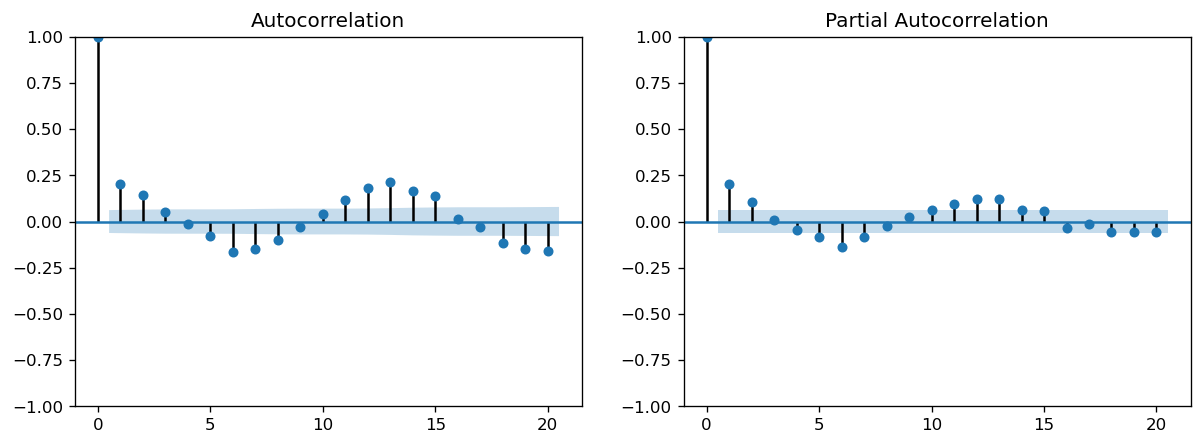

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(train_data, lags=20, ax=ax1)
plot_pacf(train_data, lags=20, ax=ax2)
plt.show()


In [24]:
p = 1
d = 0
q = 1
s = PERIOD  # Seasonal period (e.g., 12 months)
P = 1
D = 1
Q = 1

model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.46379D-01    |proj g|=  2.30849D+00


 This problem is unconstrained.



At iterate    5    f= -6.03094D-01    |proj g|=  5.92184D-01

At iterate   10    f= -6.15174D-01    |proj g|=  1.81211D-01

At iterate   15    f= -6.37374D-01    |proj g|=  1.11869D+00

At iterate   20    f= -6.46667D-01    |proj g|=  8.15450D-03

At iterate   25    f= -6.46671D-01    |proj g|=  1.94256D-02

At iterate   30    f= -6.46928D-01    |proj g|=  1.87976D-01

At iterate   35    f= -6.47237D-01    |proj g|=  9.29350D-03

At iterate   40    f= -6.47883D-01    |proj g|=  2.01990D-02

At iterate   45    f= -6.48152D-01    |proj g|=  7.00276D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     54   

In [25]:
predictions = results.get_forecast(steps=len(test_data))
mean_predictions = predictions.predicted_mean

# Calculate evaluation metrics
test_rmse = np.sqrt(mean_squared_error(test_data, mean_predictions))
test_mae = mean_absolute_error(test_data, mean_predictions)
#test_mape = np.mean(np.abs((test_data - mean_predictions) / test_data)) * 100
#test_mase = test_mae / (np.mean(np.abs(test_data[1:] - test_data[:-1])))

print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
#print(f"Test MAPE: {test_mape:.2f}%")
#print(f"Test MASE: {test_mase:.2f}")



Test RMSE: 0.14
Test MAE: 0.11


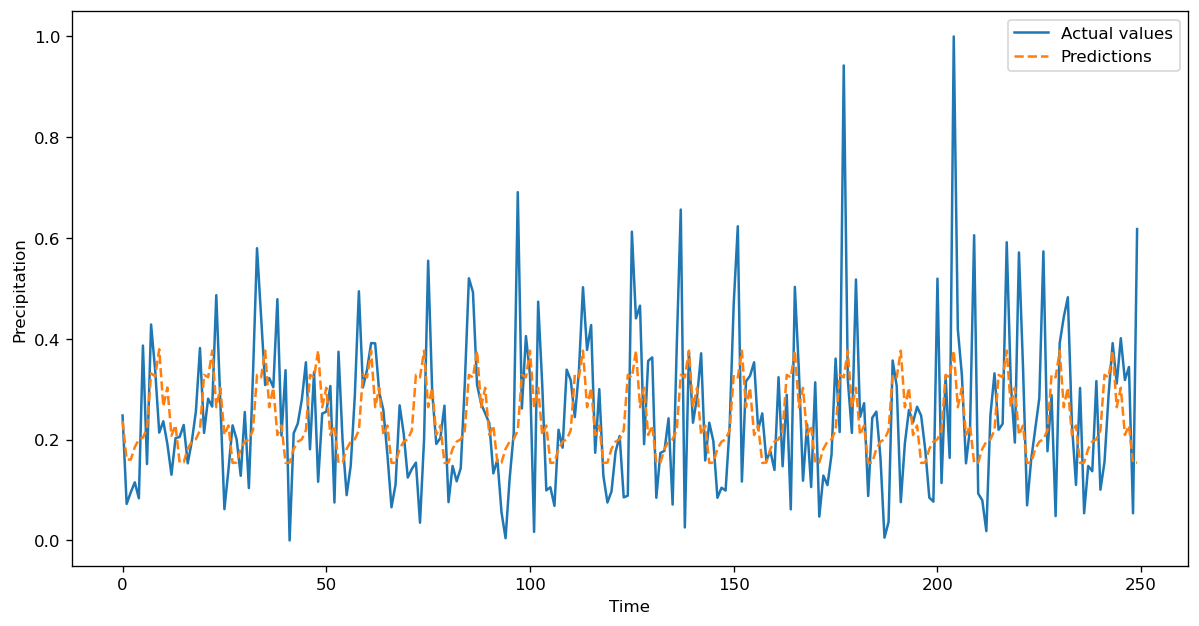

In [26]:
plt.figure(figsize=(12, 6))
#plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual values')
plt.plot(mean_predictions, label='Predictions', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Precipitation')
plt.legend()
plt.show()


## AUTO ARIMA

In [27]:
#%pip install pmdarima

In [ ]:
import pmdarima as pm

scaler = MinMaxScaler()
df_seasson = get_specific_station_data(STATION,FREQ,1800)
df_seasson = scaler.fit_transform(df_seasson)

train_data, test_data = train_test_split(df_seasson, test_size=0.2,shuffle=False)
train_data, test_data = train_test_split(df_seasson, test_size=0.2,shuffle=False)

auto_model = pm.auto_arima(train_data,
                      seasonal=True,
                      m=PERIOD,  # Seasonal frequency
                      start_p=0, start_q=0, max_p=3, max_q=3,  # Non-seasonal parameters
                      start_P=0, start_Q=0, max_P=3, max_Q=3,  # Seasonal parameters
                      d=None, D=None,  # Orders of differencing
                      trace=True,  # Print search information
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)  # Stepwise search for efficiency

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[13] intercept   : AIC=-704.914, Time=0.26 sec
 ARIMA(1,1,0)(1,0,0)[13] intercept   : AIC=-947.885, Time=2.34 sec
 ARIMA(0,1,1)(0,0,1)[13] intercept   : AIC=inf, Time=5.61 sec
 ARIMA(0,1,0)(0,0,0)[13]             : AIC=-706.907, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[13] intercept   : AIC=-943.065, Time=0.13 sec
 ARIMA(1,1,0)(2,0,0)[13] intercept   : AIC=-955.463, Time=12.13 sec
 ARIMA(1,1,0)(3,0,0)[13] intercept   : AIC=-955.002, Time=33.80 sec
 ARIMA(1,1,0)(2,0,1)[13] intercept   : AIC=inf, Time=41.41 sec
 ARIMA(1,1,0)(1,0,1)[13] intercept   : AIC=inf, Time=5.40 sec
 ARIMA(1,1,0)(3,0,1)[13] intercept   : AIC=inf, Time=87.99 sec
 ARIMA(0,1,0)(2,0,0)[13] intercept   : AIC=-710.040, Time=5.89 sec
 ARIMA(2,1,0)(2,0,0)[13] intercept   : AIC=-1029.048, Time=19.41 sec
 ARIMA(2,1,0)(1,0,0)[13] intercept   : AIC=-1017.363, Time=3.91 sec
 ARIMA(2,1,0)(3,0,0)[13] intercept   : AIC=-1032.176, Time=43.84 sec
 ARIMA(2,1,0)(3,0,1)[13] inter

In [ ]:
print(f"Best SARIMA Model: {auto_model.order}, {auto_model.seasonal_order}")

In [19]:
model = SARIMAX(train_data, order=auto_model.order, seasonal_order=auto_model.seasonal_order)
results = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.58017D-01    |proj g|=  1.25241D-01


 This problem is unconstrained.



At iterate    5    f= -5.67901D-01    |proj g|=  3.29160D-02

At iterate   10    f= -5.69018D-01    |proj g|=  4.42811D-02

At iterate   15    f= -5.69050D-01    |proj g|=  3.69772D-02

At iterate   20    f= -5.70488D-01    |proj g|=  5.02868D-02

At iterate   25    f= -5.79773D-01    |proj g|=  2.45025D-01

At iterate   30    f= -5.84780D-01    |proj g|=  1.94376D-02

At iterate   35    f= -5.88954D-01    |proj g|=  3.42860D-02

At iterate   40    f= -5.91834D-01    |proj g|=  1.66247D-02

At iterate   45    f= -5.93118D-01    |proj g|=  1.16654D-02

At iterate   50    f= -5.93381D-01    |proj g|=  9.79982D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/anaconda/envs/py38_default/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
predictions = results.get_forecast(steps=len(test_data))
mean_predictions = predictions.predicted_mean

rmse = np.sqrt(mean_squared_error(test_data, mean_predictions))
print(f"RMSE: {rmse}")


RMSE: 0.1779368245347726


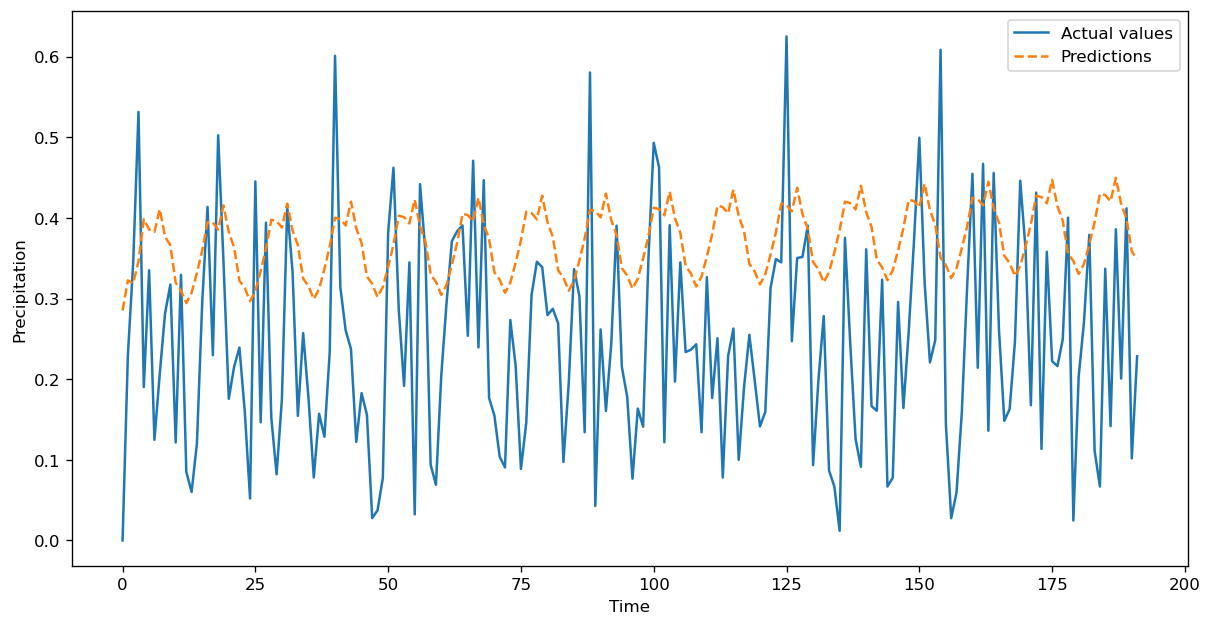

In [21]:
plt.figure(figsize=(12, 6))
#plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual values')
plt.plot(mean_predictions, label='Predictions', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Precipitation')
plt.legend()
plt.show()